#  Image augmentation with tf.image, tensorflow addons and keras.preprocessing

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from utils import *

tf.config.experimental.set_visible_devices([], 'GPU') # force CPU usage
tf.version.VERSION

'2.5.0'

In [2]:
list_of_files = sorted(glob.glob('/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/*'))
list_of_files[:4], len(list_of_files)

(['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00000-of-01024',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00001-of-01024',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00002-of-01024',
  '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/train/train-00003-of-01024'],
 1024)

In [3]:
def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label

In [4]:
image_shape = (224, 224)

def img_augmentation(image, label):
    image = tf.cast(image, tf.float32) / 127.5 - 1  # [-1, 1]
    
    def numpy_aug(image):
        keras_kwargs = dict(row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
        image = tf.keras.preprocessing.image.random_rotation(image, rg=30, **keras_kwargs)
        image = tf.keras.preprocessing.image.random_zoom(image, zoom_range=(0.9, 1.5), **keras_kwargs)
        image = tf.keras.preprocessing.image.random_shift(image, wrg=0.1, hrg=0.1, **keras_kwargs)
        image = tf.keras.preprocessing.image.random_shear(image, intensity=5, **keras_kwargs)
        return image
    image = tf.numpy_function(numpy_aug, [image], tf.float32)

    image = tf.image.resize_with_crop_or_pad(image, *image_shape)
    image = tf.image.random_flip_left_right(image)
    # colour ops:
    image = tf.image.random_brightness(image, max_delta=0.02)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

def batch_augmentation(images, labels):
    masks = tf.random.uniform([2], 15, 30, dtype=tf.int32) * 2
    images = tfa.image.random_cutout(images, mask_size=masks, constant_values=0)
    # images = tfa.image.rotate(images, angles)
    return images, labels

In [5]:
AUTO = tf.data.experimental.AUTOTUNE

dataset = tf.data.TFRecordDataset(list_of_files)
dataset = dataset.map(decode)
dataset = dataset.map(img_augmentation, num_parallel_calls=AUTO)
dataset = dataset.batch(6)
dataset = dataset.map(batch_augmentation, num_parallel_calls=AUTO)

Image shape: (6, 224, 224, 3) Labels: [844 347 619 248 343  55]


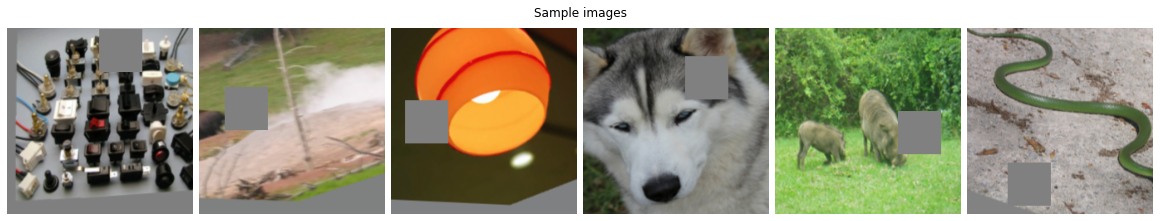

In [6]:
for images, labels in dataset.take(1):
    print('Image shape:', images.shape, 'Labels:', labels.numpy())

plot_grid(images.numpy(), 'Sample images', rows=1, figsize=(16, 3))
plt.show()

In [7]:
# inspect pixel-value distribution
np.quantile(images, [0, 0.5, 1])

array([-1.0400939 ,  0.        ,  1.02341771])